In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


In [2]:

np.random.seed(0)

# Load your data
data = pd.read_csv('state_action.csv', index_col=None)

# Select a subset of the data
data_size = 200000
selected_idx = np.random.randint(0, len(data) - 1, size=data_size)
data_select = data.iloc[selected_idx][['start_type', 'act_num', 'mode_num', 'end_type']]

print("Sample of your data:")
print(data_select.head())

# Create a DataFrame
feature_names = ['start_type', 'act_num', 'mode_num', 'end_type']
print("Sample of the dummy data:")

Sample of your data:
         start_type  act_num  mode_num  end_type
305711          2.0      3.0       2.0       2.0
1484405         0.0      0.0       0.0       0.0
2215104         0.0      0.0       0.0       0.0
963395          1.0      1.0       4.0       0.0
2249467         0.0      1.0       3.0       4.0
Sample of the dummy data:


In [3]:
# One-hot encode the data
encoder = OneHotEncoder(sparse_output=False)
one_hot_data = encoder.fit_transform(data_select.values)

# Normalize the data
from sklearn.preprocessing import StandardScaler

# Convert to PyTorch tensor
data_tensor = torch.tensor(one_hot_data, dtype=torch.float32)


In [4]:
class ScoreNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ScoreNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, sigma):
        # Append sigma as an additional feature
        sigma_expanded = sigma.unsqueeze(1)  # Shape: (batch_size, 1)
        x_sigma = torch.cat([x, sigma_expanded], dim=1)  # Shape: (batch_size, input_dim + 1)
        return self.net(x_sigma)

In [5]:
# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
input_dim = data_tensor.shape[1]
hidden_dim = 256  # Increased hidden dimension
batch_size = 256
num_epochs = 30  # Increased number of epochs
learning_rate = 1e-4  # Reduced learning rate

# Noise levels
num_noise_levels = 10

# Use PyTorch functions to create sigmas with correct dtype
sigmas = torch.exp(
    torch.linspace(np.log(0.01), np.log(1.0), num_noise_levels)
).to(device)

# Move data to device
data_tensor = data_tensor.to(device)

# Create DataLoader
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and optimizer
model = ScoreNetwork(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define step_size as a tensor
step_size = torch.tensor(0.005, device=device)  # Reduced step size for stability


Using device: cuda:1


In [6]:

losses = []  # To store loss values for plotting

for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch[0].to(device)
        batch_size = x.size(0)
        
        # Sample noise levels
        sigma_idx = torch.randint(0, num_noise_levels, (batch_size,), device=device)
        sigma = sigmas[sigma_idx]
        
        # Add noise
        noise = torch.randn_like(x) * sigma.view(-1,1)
        x_noisy = x + noise
        
        # Predict the score (gradient of log probability)
        score_pred = model(x_noisy, sigma)
        
        # Compute the loss with weighting
        loss = ((sigma.view(-1,1) * score_pred + noise / sigma.view(-1,1)) ** 2).sum(dim=1).mean()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
    avg_loss = total_loss / len(data_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")


Epoch 1/30, Loss: 23.483304
Epoch 2/30, Loss: 21.675200
Epoch 3/30, Loss: 19.696133
Epoch 4/30, Loss: 18.125799
Epoch 5/30, Loss: 17.393068
Epoch 6/30, Loss: 16.820202
Epoch 7/30, Loss: 16.372674
Epoch 8/30, Loss: 16.150051
Epoch 9/30, Loss: 15.785657
Epoch 10/30, Loss: 15.573371
Epoch 11/30, Loss: 15.335135
Epoch 12/30, Loss: 15.091126
Epoch 13/30, Loss: 14.887247
Epoch 14/30, Loss: 14.673108
Epoch 15/30, Loss: 14.412872
Epoch 16/30, Loss: 14.277706
Epoch 17/30, Loss: 14.093042
Epoch 18/30, Loss: 13.933935
Epoch 19/30, Loss: 13.743204
Epoch 20/30, Loss: 13.650382
Epoch 21/30, Loss: 13.485577
Epoch 22/30, Loss: 13.334390
Epoch 23/30, Loss: 13.239636
Epoch 24/30, Loss: 13.024304
Epoch 25/30, Loss: 12.939280
Epoch 26/30, Loss: 12.803607
Epoch 27/30, Loss: 12.664107
Epoch 28/30, Loss: 12.516166
Epoch 29/30, Loss: 12.458404
Epoch 30/30, Loss: 12.295903


In [7]:

model.eval()
num_samples_gen = 3000  # Adjust the number of samples as needed

with torch.no_grad():
    x_gen = torch.randn(num_samples_gen, input_dim).to(device) * sigmas[-1]
    
    n_steps_each = 100  # Number of steps per noise level
    
    for sigma in tqdm(reversed(sigmas), desc='Annealed Langevin Dynamics'):
        sigma_value = sigma.item()
        sigma_tensor = torch.full((num_samples_gen,), sigma_value, device=device)
        for _ in range(n_steps_each):
            noise = torch.randn_like(x_gen).to(device)
            score = model(x_gen, sigma_tensor)
            x_gen = x_gen + 0.5 * step_size * score
            x_gen += torch.sqrt(step_size) * noise

Annealed Langevin Dynamics: 100%|██████████| 10/10 [00:00<00:00, 25.74it/s]


In [9]:
x_gen_np = x_gen.cpu().numpy()
# Get the number of categories per feature
n_categories = [len(cat) for cat in encoder.categories_]
indices = np.cumsum([0] + n_categories)

# Map back to categories
generated_data = []
for sample in x_gen_np:
    sample_categories = []
    for i in range(len(n_categories)):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        logits = sample[start_idx:end_idx]
        category_idx = np.argmax(logits)
        category_value = encoder.categories_[i][category_idx]
        sample_categories.append(category_value)
    generated_data.append(sample_categories)

generated_data = np.array(generated_data)
generated_df = pd.DataFrame(generated_data, columns=['start_type', 'act_num', 'mode_num', 'end_type'])

print("\nGenerated data sample:")
print(generated_df.head())



Generated data sample:
   start_type  act_num  mode_num  end_type
0         0.0      0.0       1.0       0.0
1         0.0      0.0       0.0       0.0
2         0.0      0.0       1.0       0.0
3         0.0      1.0       0.0       0.0
4         0.0      0.0       0.0       0.0


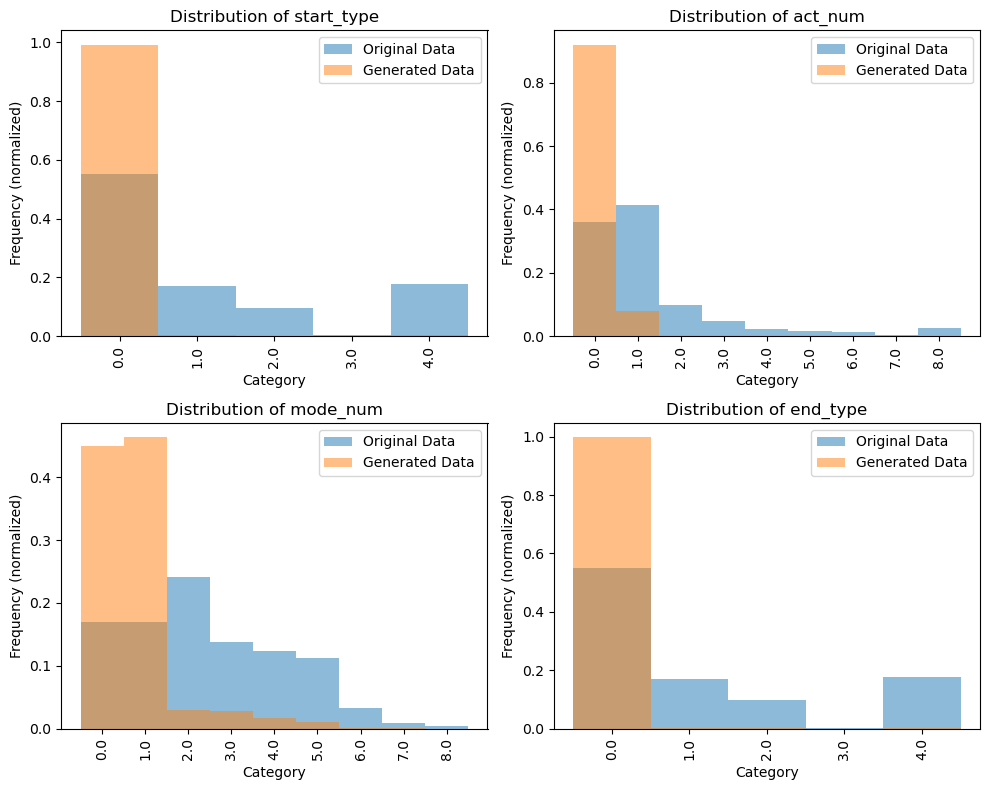

In [10]:
import matplotlib.pyplot as plt
#%% 6. Plotting the Results
# Create a 2x2 grid of subplots for the four features
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Feature names for the title and accessing columns
features = ['start_type', 'act_num', 'mode_num', 'end_type']

# Plot each feature one by one
for i, ax in enumerate(axs.flat):
    # Original data histogram
    ax.hist(data_select.values[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Original Data')

    # Generated data histogram
    ax.hist(generated_data[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Generated Data')

    # Set titles, labels, and x-axis ticks
    ax.set_title(f'Distribution of {features[i]}')
    ax.set_xlabel('Category')
    ax.set_ylabel('Frequency (normalized)')
    ax.set_xticks(range(len(encoder.categories_[i])))
    ax.set_xticklabels(encoder.categories_[i], rotation=90)

    # Add a legend to each subplot
    ax.legend()

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()
